In [1]:
import numpy as np
import os
import pandas as pd
import string
import nltk
import random
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns

In [2]:
def load_data(filename):
    BASE_DIR = os.getcwd()
    path_to_data = os.path.join(BASE_DIR, filename)
    data = pd.read_csv(path_to_data, sep = None)
    return data

In [3]:
def to_ascii(data):
    for i, s in enumerate(data['text']):
        data['text'][i] = s.encode('ascii', 'ignore')
        data['text'][i] = data['text'][i].decode('ascii').lower()
        
    return data

Task 1

In [4]:
def remove_punctuation(data):
    for i, s in enumerate(data):
        for c in string.punctuation:
            s = s.replace(c, '')
        data[i] = s
    return data

In [5]:
def get_stopwords():
    nltk.download('stopwords')
    list_of_stopwords = stopwords.words('english')
    return list_of_stopwords

In [6]:
def add_stopwords(current_list, to_expand):
    for stopword in to_expand:
        for c in string.punctuation:
            stopword = stopword.replace(c, '')
        current_list.append(stopword)
    return current_list

In [7]:
def remove_stopwords(data, stopwords):
    for i, s in enumerate(data): 
        new_text = ''
        tokens = s.split(" ")
        for word in tokens:
            if word not in stopwords:
                if 0 == len(new_text):
                    new_text = '{}'.format(word)
                else:
                    new_text = '{} {}'.format(new_text, word)
        data[i] = new_text
        
    return data

In [8]:
def preprocess_data(data, stopwords):
    data = to_ascii(data)
    
    data['text'] = remove_punctuation(data['text'])
    
    data['text'] = remove_stopwords(data['text'], stopwords)
    
    return data

Task 2

In [9]:
def get_categories(data):
    categories = []
    for categorie in data:
        if categorie not in categories:
            categories.append(categorie)
    return categories

In [10]:
def find_and_plot_top_10(data, categories):
    top_10_in_each_categorie = []
    
    fig = plt.figure(figsize=(10,10))
    num_of_plots = len(categories)
    
    for i, categorie in enumerate(categories):
        data_of_the_same_type = data[data['type'] == categorie]
        word_count = {}
        for s in data_of_the_same_type['text']:
            tokens = s.split(' ')
            for word in tokens:
                if word is not '':
                    if word in word_count.keys():
                        word_count[word] += 1
                    else:
                        word_count[word] = 1
        top_10_keys = sorted(word_count, key=word_count.get, reverse=True)[:10]
        top_10_values = []
        for key in top_10_keys:
            top_10_values.append(word_count[key])
        
        
        
        # number of graphs depends on number of categories
        # The way I want to plot is each graph under previous
        # That's why canvas will contain num_of_plots rows and 1 column
        ax = fig.add_subplot(num_of_plots, 1, i+1)
        ax.title.set_text(categorie)
        
        plt.plot(top_10_keys, top_10_values)
    plt.show()

Task 3

In [11]:
def get_tfidf_vector_and_matrix(data):
    tfidf_vectorizer = TfidfVectorizer() # Convert a collection of raw documents to a matrix of TF-IDF features
    tfidf_matrix = tfidf_vectorizer.fit_transform(data) # Learn vocabulary and idf, return term-document matrix.
    
    return tfidf_vectorizer, tfidf_matrix

Task 4

In [12]:
def plot_heat_map(data, title):
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(data, xticklabels = 10, yticklabels = 10 )
    plt.title(title)
    plt.show()

In [13]:
def pairwise_similarity(data, type_of_similarity, normalize):
    if normalize:
        data = preprocessing.normalize(data, axis = 1, norm ='l2')
        # creating part of title for sns figure
        part_of_title = 'normalized'
    else:
        part_of_title = ''
    
    if 'linear' == type_of_similarity or 'Linear' == type_of_similarity:
        K_similarity = metrics.pairwise.linear_kernel(data)
    elif 'cosine' == type_of_similarity or 'Cosine' == type_of_similarity:
        K_similarity = metrics.pairwise.cosine_similarity(data)
    else:
        raise ValueError('Unknown metrics')
    
    # Removing comparison of each pair with itself
    for i in range(len(K_similarity)): K_similarity[i,i]=0
    
    title = '{} kernel {}'.format(type_of_similarity, part_of_title)
    plot_heat_map(K_similarity, title)
    
    
    return K_similarity

Task 5

In [14]:
def get_labels(data):
    labels = np.zeros(data.shape[0])
    label = 0
    ind_start = 0
    ind_end = 0

    list_of_unique_labels = []

    for categorie in categories:
        temp_data = data[data['type'] == categorie]
        ind_end += temp_data.shape[0]
        labels[ind_start:ind_end] = label

        if label not in list_of_unique_labels:
            list_of_unique_labels.append(label)
        label += 1
        ind_start = ind_end
    return labels, list_of_unique_labels

In [15]:
def K_most_similar(paiwise_similarities, k, labels, list_of_unique_labels, print_individual):
    if k < 1:
        raise ValueError("Too small value for k, k has to be larger than 1.")
    predicted_labels = np.zeros_like(labels)
    
    for i, sample in enumerate(paiwise_similarities):
        sort_idx = np.argsort(-paiwise_similarities[i])
        # first element represents similarity of sample to itself, so we exclude it
        k_most_similar = paiwise_similarities[i][sort_idx][1:k+1]
        k_most_similar_labels = labels[sort_idx][1:k+1]
        similar = 0
        
        for label in list_of_unique_labels:
            count = np.where(k_most_similar_labels == label)
            
            if similar < count[0].size:
                similar = count[0].size
                predicted_label = label
        predicted_labels[i] = predicted_label
        if print_individual:
            print("# {} -- labels: {} -- predicted: {}".format(i, k_most_similar_labels, predicted_label))
    correctly_predicted = np.where(labels == predicted_labels)[0].size
    avg_acc = correctly_predicted / sample.size
    print("Correctly predicted {} with average accuracy {} for {} most similar samples".format(correctly_predicted, avg_acc, k))   

Task 7

In [16]:
def random_word(lst):
    n = len(lst)
    rand_idx = random.randint(0, n-1)
    return lst[rand_idx]

In [17]:
def get_list_of_words(data):
    list_of_words = []
    for sample in data['text']:
        words = sample.split(' ')
        for word in words:
            if word not in list_of_words:
                list_of_words.append(word)
    return list_of_words

In [18]:
def get_distribution(data):
    list_of_words = get_list_of_words(data)
    distribution = {}
    for word in list_of_words:
        probabilities = {}
        count = 0
        # search for selected word in dataframe and takes word that comes after it
        for sample in data['text']:
            tokens = sample.split(' ')
            for i, token in enumerate(tokens):
                if word == token:
                    # if word is the last word in sample than do nothing
                    try:
                        if tokens[i+1] not in probabilities.keys():
                            probabilities[tokens[i+1]] = 1
                        else:
                            probabilities[tokens[i+1]] += 1
                        count += 1
                    except:
                        pass
        
        for w in probabilities:
            probabilities[w] /= count
        
        distribution[word] = probabilities
    
    return distribution

In [19]:
def predict_next_word(word, distribution):
    # taking only the distribution for the words that comes after our word
    probabilities = distribution[word]   
    possible_words = list(probabilities.keys())
    
    word_predicted = False
    while not word_predicted:
        # Criteria for prediction is not perfect
        # First we choose random word from list of possible words
        # Then we decide to either keep or discard chosen word based on its probability of occurrence after the current word
        # If list of possible word is empty then we choose random word from all words
        try:
            candidate_word = random_word(possible_words)
            if random.random() <= probabilities[candidate_word]:
                predicted_word = candidate_word
                word_predicted = True
        except:
            all_words = list(distribution.keys())
            predicted_word = random_word(all_words)
            word_predicted = True
    
    return predicted_word

In [20]:
def generate_new_sample(data, categorie, length):
    new_sample = ''
    
    data = data[data['type'] == categorie]
    list_of_words = get_list_of_words(data)
    # It is possible to calculate distribution outside the function and pass it like an function argument
    # That would improve execution time of this function
    # But this approach was more aestheticly pleasing
    
    distribution = get_distribution(data)
    
    i = 0
    while(i < length):
        if 0 == len(new_sample):
            next_word = random_word(list_of_words) # aestetics reasons
            new_sample = next_word
        else:
            next_word = predict_next_word(current_word, distribution)
            new_sample = '{} {}'.format(new_sample, next_word)
        current_word = next_word
        i += 1
    return new_sample

The New York Times

In [21]:
data_news = load_data('news.tab')

In [22]:
data_news = data_news.drop('Unnamed: 2', axis=1)

In [23]:
data_news

,type,text
0,technology,Open the mobile phone application offered by a...
1,technology,and give crime statistics for a specific area....
2,technology,thousand downloads a week. “The feedback has b...
3,technology,"the technology for a similar range of uses, in..."
4,technology,Telecom Industry Ripe for Consolidation The Me...
5,technology,"billion in 2005, according to Mergermarket, an..."
6,technology,"mobile markets are mature and static, with a h..."
7,technology,more confidence that investors will not penali...
8,technology,"Technology Can Improve Healthcare In 1900, an ..."
9,technology,affordable and useful – Web sites with persona...


In [24]:
stopwords = get_stopwords()

stopwords = remove_punctuation(stopwords)

extra_stopwords = ['would', 'said', 'like', 'also', 'could', 'still']
stopwords = add_stopwords(stopwords, extra_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
data_news = preprocess_data(data_news, stopwords)

In [26]:
data_news

,type,text
0,technology,open mobile phone application offered french r...
1,technology,give crime statistics specific area ar beatles...
2,technology,thousand downloads week feedback totally great...
3,technology,technology similar range uses including real e...
4,technology,telecom industry ripe consolidation mexican bi...
5,technology,billion 2005 according mergermarket analysis f...
6,technology,mobile markets mature static handful operators...
7,technology,confidence investors penalize companies pursui...
8,technology,technology improve healthcare 1900 american ma...
9,technology,affordable useful web sites personal data bas...


In [27]:
categories = get_categories(data_news['type'])

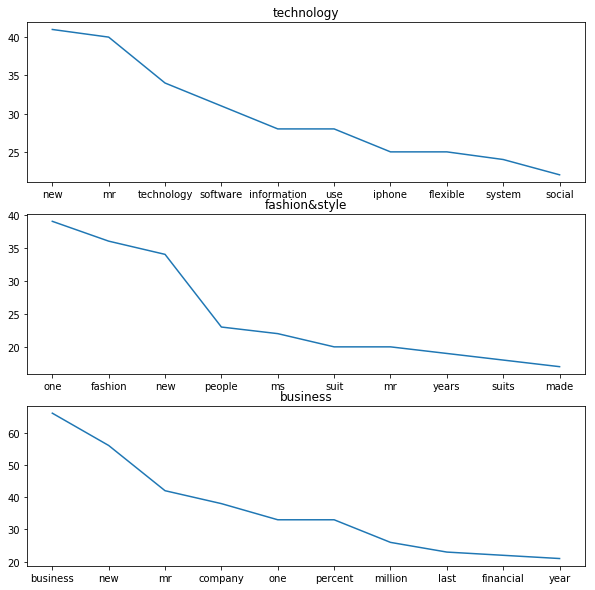

In [28]:
find_and_plot_top_10(data_news, categories)

In [29]:
tfidf_vectorizer, tfidf_matrix = get_tfidf_vector_and_matrix(data_news['text'])

In [30]:
tfidf_data = pd.DataFrame(data=tfidf_matrix.todense(), columns=tfidf_vectorizer.get_feature_names())
# tfidf_data

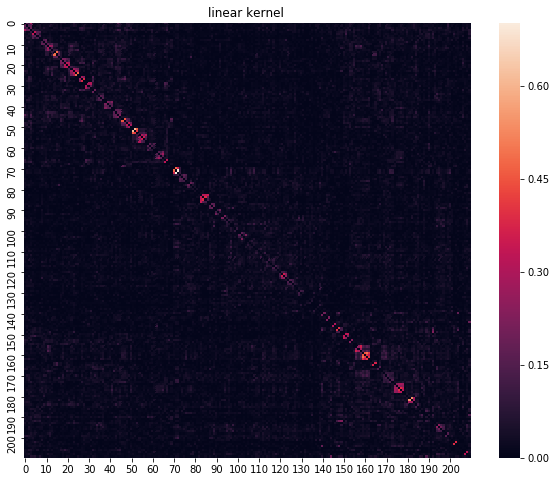

In [31]:
K_linear = pairwise_similarity(tfidf_data, 'linear', False)

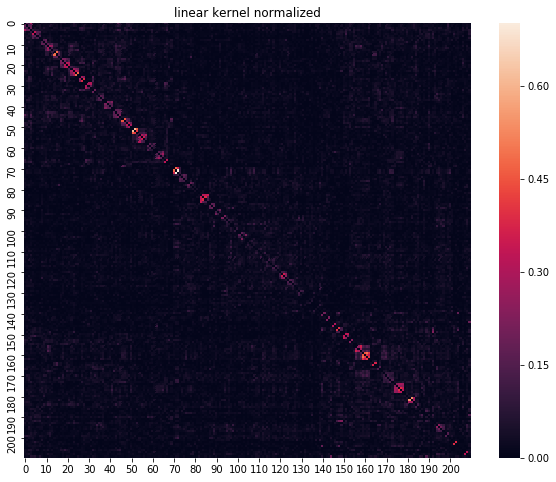

In [32]:
K_norm_linear = pairwise_similarity(tfidf_data, 'linear', True) # Normalization didn't do much because tfidf matrix is sparse.

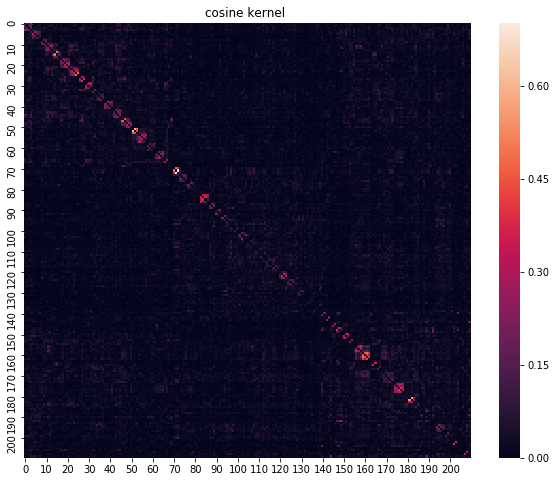

In [33]:
K_cosine = pairwise_similarity(tfidf_data, 'cosine', False)

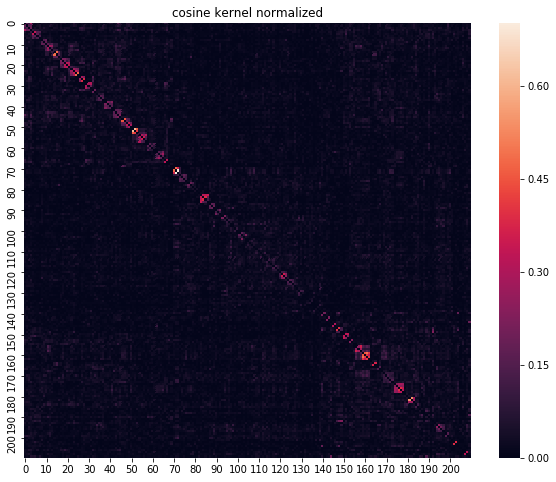

In [34]:
K_norm_cosine = pairwise_similarity(tfidf_data, 'cosine', True)

In [35]:
labels, list_of_unique_labels = get_labels(data_news)

In [36]:
K_most_similar(K_norm_cosine, 5, labels, list_of_unique_labels, True) # Categorization

# 0 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 1 -- labels: [0. 0. 2. 0. 0.] -- predicted: 0
# 2 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 3 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 4 -- labels: [0. 0. 0. 2. 0.] -- predicted: 0
# 5 -- labels: [0. 2. 2. 0. 2.] -- predicted: 2
# 6 -- labels: [0. 0. 0. 2. 2.] -- predicted: 0
# 7 -- labels: [0. 0. 2. 2. 2.] -- predicted: 2
# 8 -- labels: [0. 1. 2. 0. 0.] -- predicted: 0
# 9 -- labels: [0. 2. 2. 0. 2.] -- predicted: 2
# 10 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 11 -- labels: [0. 0. 2. 0. 2.] -- predicted: 0
# 12 -- labels: [0. 0. 0. 2. 2.] -- predicted: 0
# 13 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 14 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 15 -- labels: [0. 2. 2. 0. 0.] -- predicted: 0
# 16 -- labels: [0. 1. 2. 0. 2.] -- predicted: 0
# 17 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 18 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 19 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 20 -- labels: [0. 0. 0. 2. 2

In [37]:
for i in range(2, 20):
    K_most_similar(K_norm_linear, i, labels, list_of_unique_labels, False)

Correctly predicted 169 with average accuracy 0.8047619047619048 for 2 most similar samples
Correctly predicted 181 with average accuracy 0.861904761904762 for 3 most similar samples
Correctly predicted 183 with average accuracy 0.8714285714285714 for 4 most similar samples
Correctly predicted 181 with average accuracy 0.861904761904762 for 5 most similar samples
Correctly predicted 180 with average accuracy 0.8571428571428571 for 6 most similar samples
Correctly predicted 180 with average accuracy 0.8571428571428571 for 7 most similar samples
Correctly predicted 179 with average accuracy 0.8523809523809524 for 8 most similar samples
Correctly predicted 174 with average accuracy 0.8285714285714286 for 9 most similar samples
Correctly predicted 176 with average accuracy 0.8380952380952381 for 10 most similar samples
Correctly predicted 170 with average accuracy 0.8095238095238095 for 11 most similar samples
Correctly predicted 171 with average accuracy 0.8142857142857143 for 12 most sim

Task 6 - Vogue

In [38]:
data_vogue = load_data('vogue.txt')

In [39]:
data_vogue = data_vogue.drop('Unnamed: 2', axis=1)

In [40]:
data_vogue = preprocess_data(data_vogue, stopwords)

In [41]:
data_vogue

,type,text
0,hair,mean flaunt red hair whether born way rare sel...
1,hair,roster ravishing redheads tell us dazzling car...
2,hair,best friend child natural redhead hated got pi...
3,hair,always felt quite drab comparison asked whethe...
4,hair,victorians popularized mystical symbolism hair...
5,hair,verucca salt bratty teenage eastern european f...
6,hair,andersson flirting red hair since 13 experienc...
7,hair,predicted turning sable locks scarlet allowing...
8,hair,wearing hair natural makes feel im giving fing...
9,hair,occasional red hair stunning irreverent choppi...


In [42]:
categories = get_categories(data_vogue['type'])

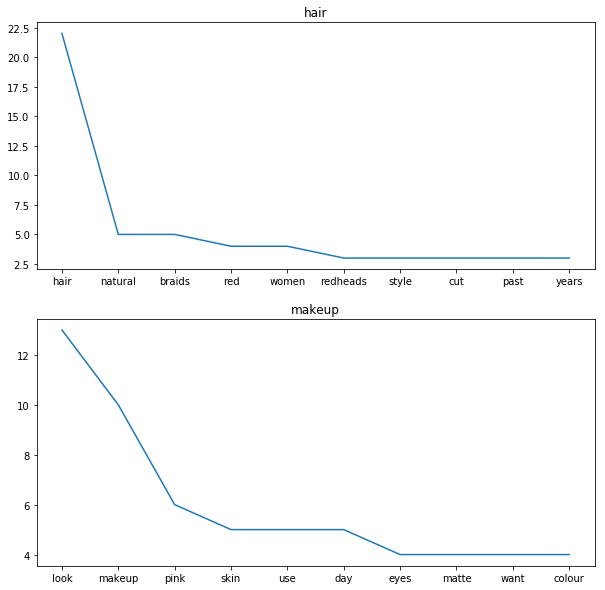

In [43]:
find_and_plot_top_10(data_vogue, categories)

In [44]:
tfidf_vectorizer, tfidf_matrix = get_tfidf_vector_and_matrix(data_vogue['text'])

In [45]:
tfidf_data = pd.DataFrame(data=tfidf_matrix.todense(), columns=tfidf_vectorizer.get_feature_names())
# tfidf_data

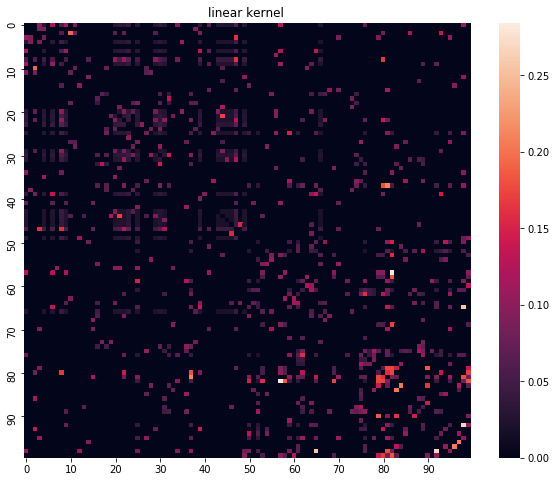

In [46]:
K_linear = pairwise_similarity(tfidf_data, 'linear', False)

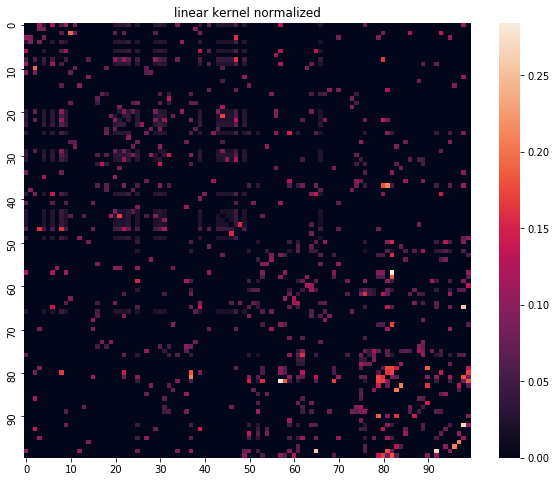

In [47]:
K_norm_linear = pairwise_similarity(tfidf_data, 'linear', True) # Normalization didn't do much because tfidf matrix is sparse.

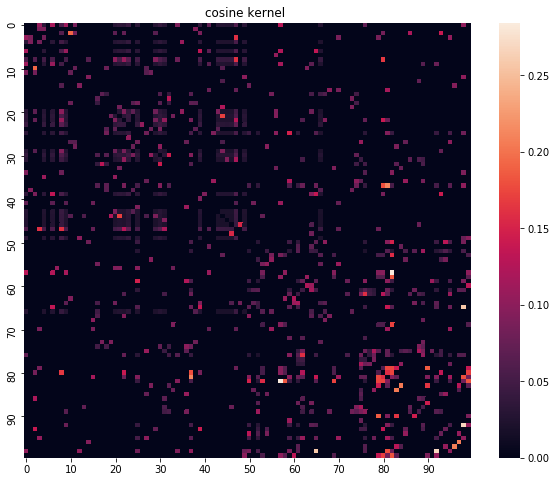

In [48]:
K_cosine = pairwise_similarity(tfidf_data, 'cosine', False)

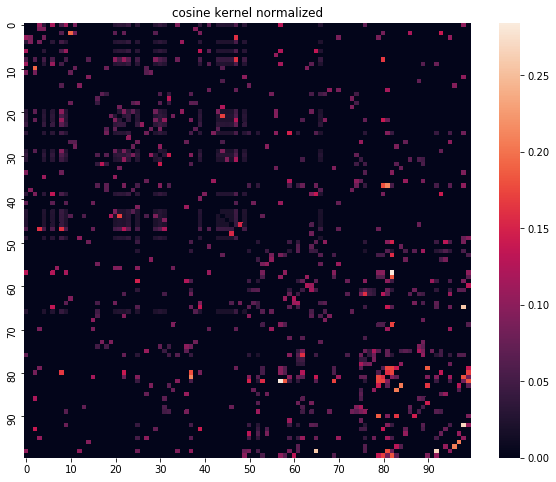

In [49]:
K_norm_cosine = pairwise_similarity(tfidf_data, 'cosine', True)

In [50]:
labels, list_of_unique_labels = get_labels(data_vogue)

In [51]:
K_most_similar(K_norm_cosine, 5, labels, list_of_unique_labels, True) # Categorization

# 0 -- labels: [0. 0. 0. 1. 0.] -- predicted: 0
# 1 -- labels: [0. 0. 0. 1. 1.] -- predicted: 0
# 2 -- labels: [1. 1. 0. 0. 1.] -- predicted: 1
# 3 -- labels: [0. 1. 0. 1. 1.] -- predicted: 1
# 4 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 5 -- labels: [1. 1. 1. 1. 1.] -- predicted: 1
# 6 -- labels: [0. 1. 0. 0. 0.] -- predicted: 0
# 7 -- labels: [0. 1. 1. 1. 1.] -- predicted: 1
# 8 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 9 -- labels: [0. 0. 1. 1. 0.] -- predicted: 0
# 10 -- labels: [1. 0. 0. 0. 0.] -- predicted: 0
# 11 -- labels: [0. 0. 0. 0. 1.] -- predicted: 0
# 12 -- labels: [0. 0. 1. 1. 1.] -- predicted: 1
# 13 -- labels: [0. 0. 1. 1. 1.] -- predicted: 1
# 14 -- labels: [0. 1. 0. 1. 1.] -- predicted: 1
# 15 -- labels: [1. 1. 0. 0. 0.] -- predicted: 0
# 16 -- labels: [0. 0. 0. 1. 1.] -- predicted: 0
# 17 -- labels: [1. 0. 0. 1. 1.] -- predicted: 1
# 18 -- labels: [0. 0. 0. 0. 0.] -- predicted: 0
# 19 -- labels: [1. 0. 0. 1. 1.] -- predicted: 1
# 20 -- labels: [0. 1. 0. 0. 0

In [52]:
for i in range(2, 20):
    K_most_similar(K_norm_linear, i, labels, list_of_unique_labels, False)

Correctly predicted 76 with average accuracy 0.76 for 2 most similar samples
Correctly predicted 76 with average accuracy 0.76 for 3 most similar samples
Correctly predicted 81 with average accuracy 0.81 for 4 most similar samples
Correctly predicted 71 with average accuracy 0.71 for 5 most similar samples
Correctly predicted 74 with average accuracy 0.74 for 6 most similar samples
Correctly predicted 69 with average accuracy 0.69 for 7 most similar samples
Correctly predicted 71 with average accuracy 0.71 for 8 most similar samples
Correctly predicted 72 with average accuracy 0.72 for 9 most similar samples
Correctly predicted 72 with average accuracy 0.72 for 10 most similar samples
Correctly predicted 70 with average accuracy 0.7 for 11 most similar samples
Correctly predicted 69 with average accuracy 0.69 for 12 most similar samples
Correctly predicted 69 with average accuracy 0.69 for 13 most similar samples
Correctly predicted 69 with average accuracy 0.69 for 14 most similar sam

In [53]:
data = pd.concat([data_vogue, data_news]).reset_index(drop=True)

In [54]:
categories = get_categories(data['type'])

In [55]:
for i in range(10):
    categorie = random_word(categories)
    sample_length = random.randint(5, 15)
    new_sample = generate_new_sample(data, categorie, sample_length)
    print('Sample {}; categorie {}; length {}'.format(i, categorie, sample_length))
    print(new_sample + '\n')

Sample 0; categorie technology; length 11
diagnostic mechanism used vehicles today screen certain broadcom cards triulzi able

Sample 1; categorie business; length 12
holdings district reflects essence american land title search terms creating mortgagerelated securities

Sample 2; categorie fashion&style; length 8
exclusively store aimed fashionistas consider lycra bike shorts

Sample 3; categorie technology; length 15
seating activity come mobile broadband service conducting official departmentrelated business plans expand french agency emeryville

Sample 4; categorie technology; length 12
bodies computer networking cards exist detection techniques used strictly determine characteristics age

Sample 5; categorie technology; length 12
inevitable stuff build augmented reality system augment information find virtual goods time

Sample 6; categorie fashion&style; length 6
1490 4795 nice new york magazine

Sample 7; categorie fashion&style; length 6
animal prints exert strong sculptural el